<a href="https://colab.research.google.com/github/Swastik-Swarup-Dash/Machine-Learning/blob/main/Tranfer_learning_Fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2024-06-01 08:58:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-01 08:58:00 (15.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-06-01 08:58:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   140MB/s    in 1.2s    

2024-06-01 08:58:07 (140 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:

# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


24274472/24274472 [==============================] - 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240601-085821
Epoch 1/5
24/24 [==============================] - 21s 257ms/step - loss: 1.8846 - accuracy: 0.4120 - val_loss: 1.3204 - val_accuracy: 0.7582
Epoch 2/5
24/24 [==============================] - 4s 169ms/step - loss: 1.1189 - accuracy: 0.7733 - val_loss: 0.8858 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 5s 178ms/step - loss: 0.8217 - accuracy: 0.8307 - val_loss: 0.7061 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 4s 167ms/step - loss: 0.6747 - accuracy: 0.8587 - val_loss: 0.6074 - val_accuracy: 0.8602
Epoch 5/5
24/24 [==============================] - 5s 177ms/step - loss: 0.5835 - accuracy: 0.8867 - val_loss: 0.5644 - val_accuracy: 0.8668


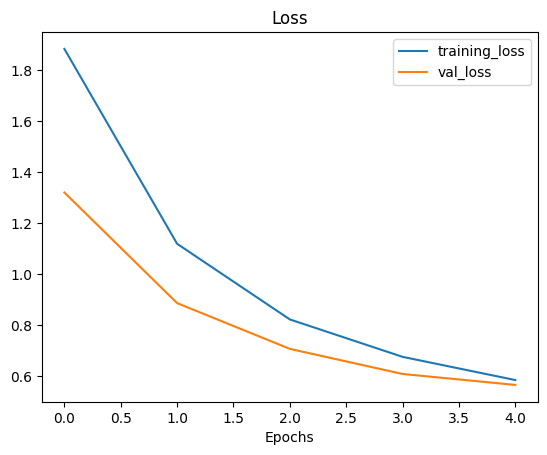

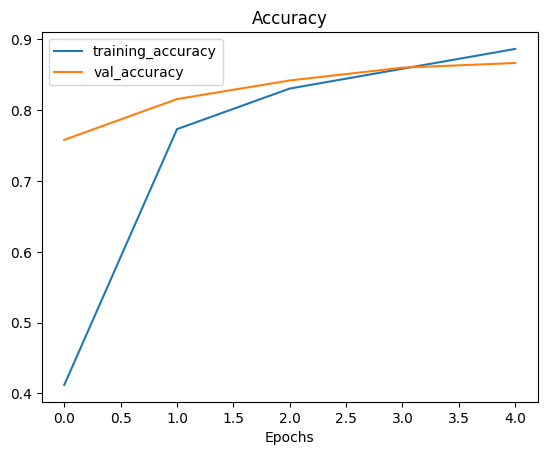

In [ ]:

# Check out our model's training curves
plot_loss_curves(history_10_percent)


In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:


# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"


--2024-06-01 08:59:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  43.3MB/s    in 2.9s    

2024-06-01 08:59:06 (43.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:

# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

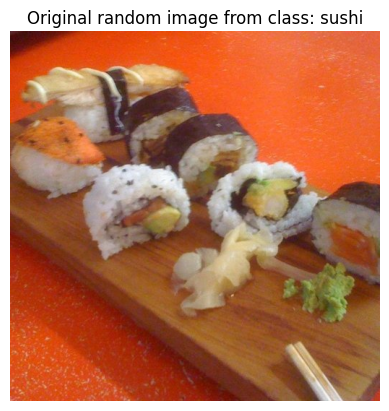

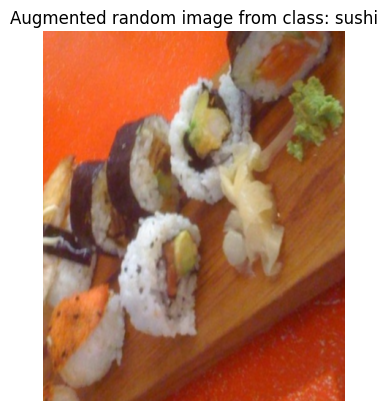

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240601-085912
Epoch 1/5
3/3 [==============================] - 16s 3s/step - loss: 2.3745 - accuracy: 0.1000 - val_loss: 2.2030 - val_accuracy: 0.1941
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.1847 - accuracy: 0.2286 - val_loss: 2.0850 - val_accuracy: 0.2829
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9796 - accuracy: 0.2857 - val_loss: 1.9804 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8055 - accuracy: 0.4714 - val_loss: 1.8853 - val_accuracy: 0.4260
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 1.7020 - accuracy: 0.5429 - val_loss: 1.8127 - val_accuracy: 0.4589


In [ ]:
results_1_percenT_data_aug = model_1.evaluate(test_data)
results_1_percenT_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.8245 - accuracy: 0.4628


[1.82451331615448, 0.462799996137619]

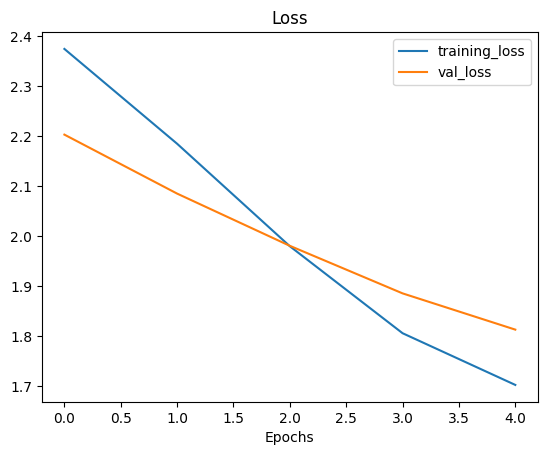

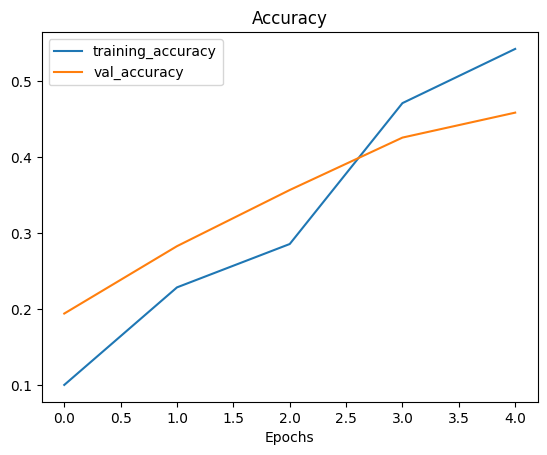

In [ ]:
plot_loss_curves(history_1_percent)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-06-01 09:00:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  76.7MB/s    in 2.1s    

2024-06-01 09:00:08 (76.7 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir  = "10_food_classes_10_percent/test"

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent_aug = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                               image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")

test_data_10_percent_aug = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                               image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation_10 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)

],name="data_augmentation_10")

In [55]:
#Create a Base_model
base_model_10 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model_10.trainable = False

input = layers.Input(shape=(224,224,3),name="Input_shape")

x = data_augmentation_10(input)
x = base_model_10(x,training=False)

x = layers.GlobalAveragePooling2D(name="Global_average_Pooling")(x)

output = layers.Dense(10,activation="softmax",name="Output_layers")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(input, output)

model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

history_2_10 = model_2.fit(train_data_10_percent_aug,epochs=5,steps_per_epoch=len(train_data_10_percent_aug),validation_data=test_data_10_percent_aug,
                            validation_steps=int(0.25* len(test_data_10_percent_aug)))


AttributeError: 'Activation' object has no attribute 'Input'

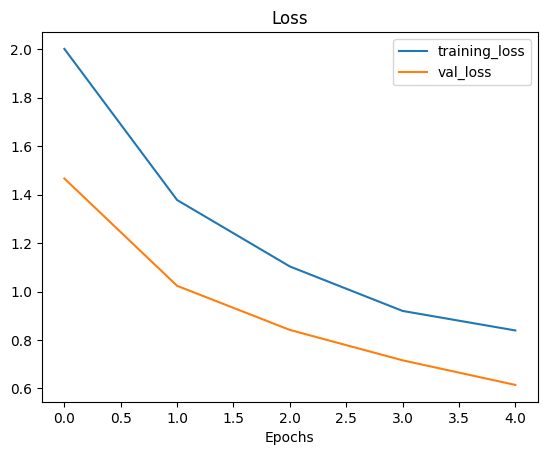

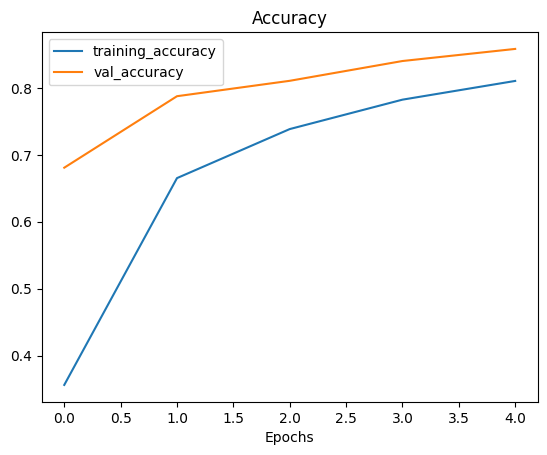

In [ ]:
plot_loss_curves(history_2_10)

In [ ]:
result_2_10 = model_2.evaluate(test_data_10_percent_aug)
result_2_10

79/79 [==============================] - 5s 59ms/step - loss: 0.6472 - accuracy: 0.8336


[0.6471686363220215, 0.8335999846458435]

In [ ]:
model_2.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_10 (Sequ  (None, None, None, 3)     0         
 ential)                                                         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_average_Pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 Output_layers (Dense)       (None, 10)                12810     
                                                           

In [ ]:


def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [ ]:

# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [51]:
initial_epoch = 5
history_2_10 = model_2.fit(train_data_10_percent_aug,epochs=initial_epoch,steps_per_epoch=len(train_data_10_percent_aug),validation_data=test_data_10_percent_aug,
                            validation_steps=int(0.25* len(test_data_10_percent_aug)),
                            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240601-095951
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8720
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 633ms/step - loss: 0.5294 - accuracy: 0.8720 - val_loss: 0.5084 - val_accuracy: 0.8651
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8720
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 880ms/step - loss: 0.5236 - accuracy: 0.8720 - val_loss: 0.4896 - val_accuracy: 0.8618
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8627
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 649ms/step - loss: 0.5421 - accuracy: 0.8627 - val_loss: 0.4710 - val_accuracy: 0.8701
E

In [ ]:
result_2_10 = model_2.evaluate(test_data_10_percent_aug)
result_2_10

79/79 [==============================] - 5s 58ms/step - loss: 0.5016 - accuracy: 0.8548


[0.5016027092933655, 0.8547999858856201]

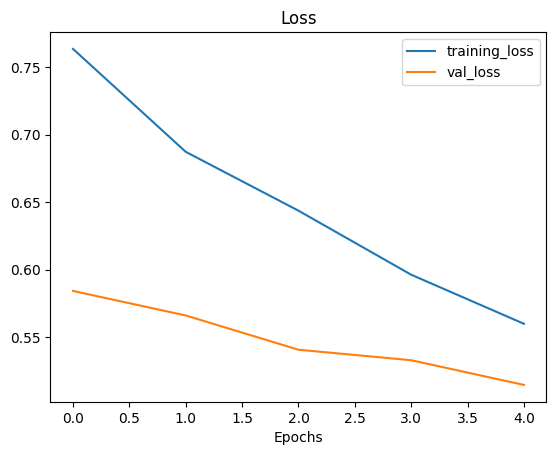

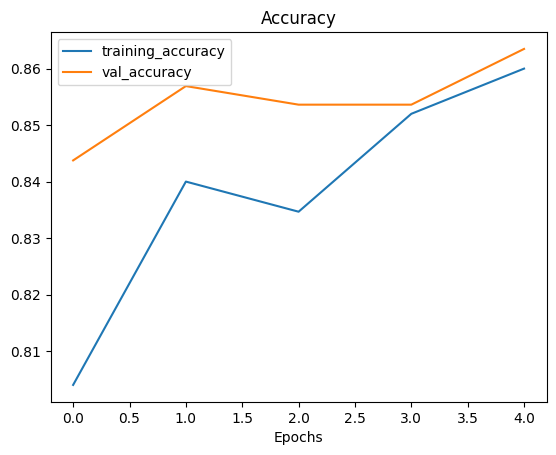

In [ ]:
plot_loss_curves(history_2_10)

In [ ]:
model_0.evaluate(test_data_10_percent_aug)

79/79 [==============================] - 7s 77ms/step - loss: 0.5668 - accuracy: 0.8620


[0.5668133497238159, 0.8619999885559082]

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weughts_models_results = model_2.evaluate(test_data_10_percent_aug)

79/79 [==============================] - 5s 58ms/step - loss: 0.5016 - accuracy: 0.8548


In [ ]:
result_2_10 == loaded_weughts_models_results

True

#Fine Tuning

In [59]:
#Layers in our Loaded Model
model_2.layers

In [82]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79ff88594280> True
<keras.src.engine.sequential.Sequential object at 0x79ff84fb0a60> True
<keras.src.engine.functional.Functional object at 0x79ff84ddab00> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x79ff84bb48b0> True
<keras.src.layers.core.dense.Dense object at 0x79ff84f740d0> True


In [83]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [84]:
#How many trainable variable in our Base Model
print(len(model_2.layers[2].trainable_variables))

0


In [85]:
# To begin Fine tuning lets sets last 10 to trainable = TRue
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile our Model everytime we make a Change
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [64]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [65]:
fine_tune_epoch = initial_epoch + 5

history_fine_tune_10 = model_2.fit(train_data_10_percent_aug,epochs=fine_tune_epoch,steps_per_epoch=len(train_data_10_percent_aug),validation_data=test_data_10_percent_aug,
                            validation_steps=int(0.25* len(test_data_10_percent_aug)),
                            initial_epoch = history_2_10.epoch[-1],
                            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_data_aug/20240601-102228
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8813
Epoch 5: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 641ms/step - loss: 0.4773 - accuracy: 0.8813 - val_loss: 0.4588 - val_accuracy: 0.8750
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.4929 - accuracy: 0.8787
Epoch 6: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 488ms/step - loss: 0.4929 - accuracy: 0.8787 - val_loss: 0.4288 - val_accuracy: 0.8898
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.4904 - accuracy: 0.8720
Epoch 7: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 460ms/step - loss: 0.4904 - accuracy: 0.8720 - val_loss: 0.4299 - val_accur

In [66]:
results_fine_tune_10_percent = model_2.evaluate(test_data_10_percent_aug)


79/79 [==============================] - 6s 64ms/step - loss: 0.4607 - accuracy: 0.8616


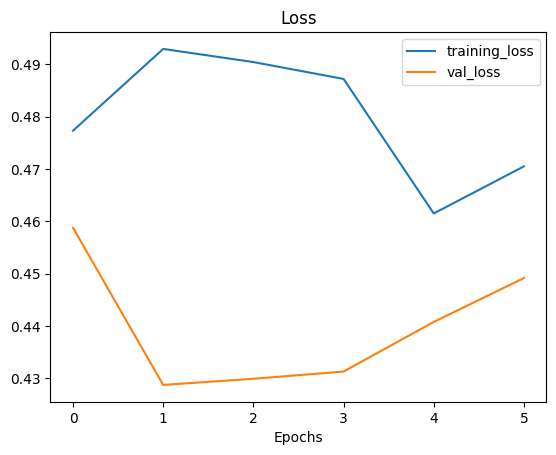

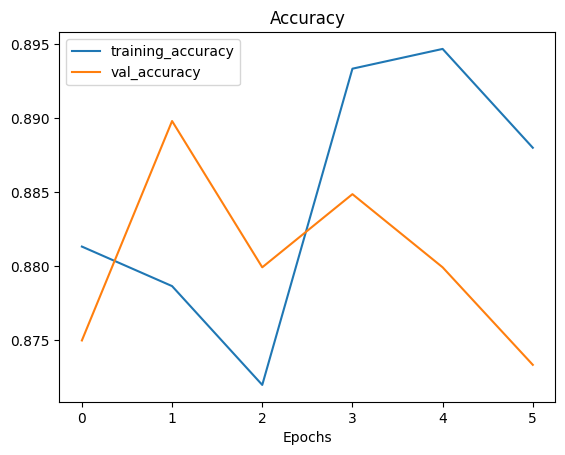

In [67]:
plot_loss_curves(history_fine_tune_10)

In [68]:


def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)


     # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.871999979019165, 0.871999979019165, 0.862666666507721, 0.8573333621025085, 0.8773333430290222, 0.8813333511352539, 0.8786666393280029, 0.871999979019165, 0.8933333158493042, 0.8946666717529297, 0.8880000114440918]


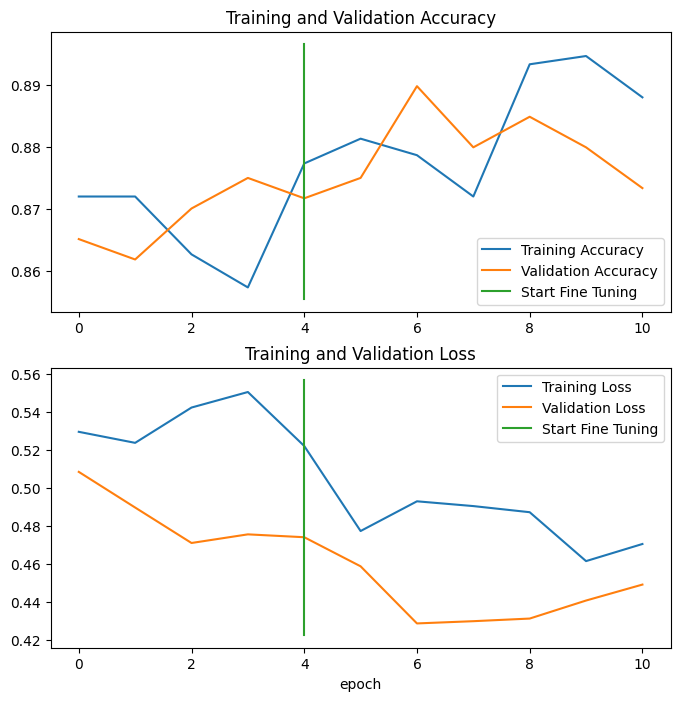

In [69]:
compare_historys(history_2_10,history_fine_tune_10 ,5)

In [71]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-06-01 10:25:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   221MB/s    in 2.2s    

2024-06-01 10:25:25 (221 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [72]:
# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [73]:

# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")


There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [74]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [75]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.4607 - accuracy: 0.8616


[0.46066367626190186, 0.8615999817848206]

In [76]:
results_fine_tune_10_percent

[0.460663765668869, 0.8615999817848206]

To keep our experiments clean, we'll load a create a new instance of model_2 using our create_base_model() function.

More specifically, we're trying to measure:

Experiment 3 (previous one) - model_2 with 10 layers fine-tuned for 5 more epochs on 10% of the data.
Experiment 4 (this one) - model_2 with layers fined-tuned for 5 more epochs on 100% on the data.
Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (model_2 feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of model_2.

In [77]:
model_2.load_weights(checkpoint_path)

In [80]:
##Lets evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.4607 - accuracy: 0.8616


[0.460663765668869, 0.8615999817848206]

In [86]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [87]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [89]:
fine_tune_epochs = initial_epoch + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_2_10.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240601-104422
Epoch 5/10
235/235 [==============================] - 92s 357ms/step - loss: 0.7232 - accuracy: 0.7764 - val_loss: 0.4349 - val_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 78s 328ms/step - loss: 0.6902 - accuracy: 0.7907 - val_loss: 0.4117 - val_accuracy: 0.8734
Epoch 7/10
235/235 [==============================] - 64s 270ms/step - loss: 0.6706 - accuracy: 0.7919 - val_loss: 0.3939 - val_accuracy: 0.8816
Epoch 8/10
235/235 [==============================] - 62s 261ms/step - loss: 0.6508 - accuracy: 0.7999 - val_loss: 0.3848 - val_accuracy: 0.8766
Epoch 9/10
235/235 [==============================] - 57s 239ms/step - loss: 0.6418 - accuracy: 0.8031 - val_loss: 0.3982 - val_accuracy: 0.8717
Epoch 10/10
235/235 [==============================] - 53s 223ms/step - loss: 0.6266 - accuracy: 0.8049 - val_loss: 0.3767 - val_accuracy: 0.8783


In [90]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 67ms/step - loss: 0.3841 - accuracy: 0.8808


[0.3840579390525818, 0.8808000087738037]

In [91]:
results_fine_tune_10_percent

[0.460663765668869, 0.8615999817848206]

6
12
[0.8813333511352539, 0.8786666393280029, 0.871999979019165, 0.8933333158493042, 0.8946666717529297, 0.8880000114440918, 0.7764000296592712, 0.7906666398048401, 0.791866660118103, 0.7998666763305664, 0.8030666708946228, 0.8049333095550537]


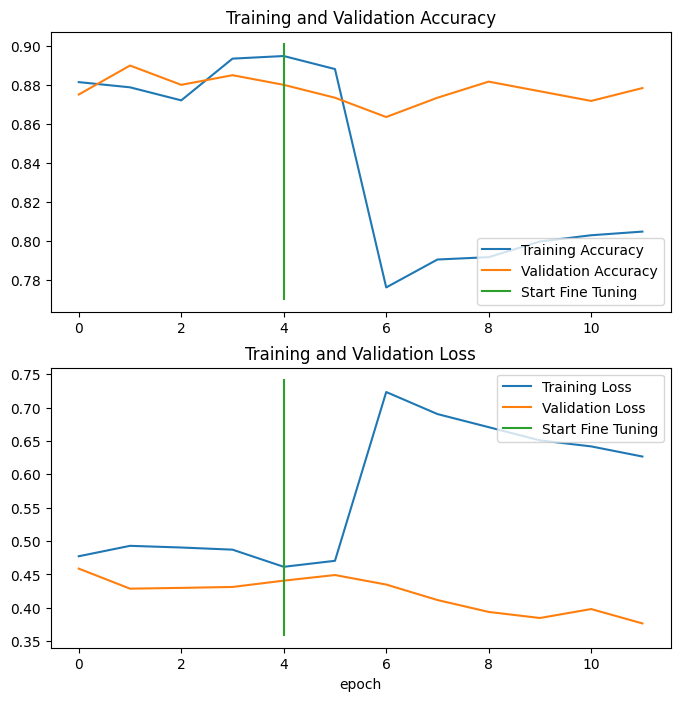

In [94]:
compare_historys(original_history=history_fine_tune_10,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)